The Polynomial Regression can be implemented by:
- The OLS method
- The Gradient Descent Approach

In this notebook, we perform polynomial linear regression using Scikit-Learn's OLS Linear Regression model.
Note that the OLS method is suitable for the following scenarios.
- Dataset: not too large and fits into computer's memory
- No. of Features: not too large
The problem with the high-degree Polynomial Regression model is that it may severely overfit the training data. In other words, our Polynomial model may have high variance.<br>
On the other hand, a linear model (no polynomial features) may underfit (high bias) the trining data. In general we won’t know what function (the exact degree of the polynomial) generated the data. Then, how can we decide how complex (the degree of polynomial) our model should be? How can we tell that our model is overfitting or underfitting the training data?

**Choosing Model Complexity in High-Degree Polynomial Regression**<br>
There are two approaches to make an optimal tradeoff between overfitting (high variance) and underfitting (high bias).<br>
**Frequentist Learning:**
- Using cross-validation determine the optimal degree (model complexity) that produces best generalization.
- Using learning curve determine the optimal degree (model complexity) that produces best generalization.<br>

**Bayesian Learning (regularized regression):**
- Using cross-validation learn the optimal regularization (penalty) coefficients that produce best generalization

**How do we augment features?**<br>
We use Scikit-Learn’s PolynomialFeatures class to transform our training data, adding the higher-degree polynomial of each feature in the training set as new features. PolynomialFeatures also adds all combinations of features up to the given degree.

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [ ]:
# Load data
from sklearn.datasets import fetch_openml
boston = fetch_openml(name="boston", version=1, as_frame=True)
print(boston.data.shape, boston.target.shape)
print(boston.feature_names)

df = pd.DataFrame(boston.data,columns=boston.feature_names)
df = pd.concat([df,pd.Series(boston.target,name='MEDV')],axis=1)
df.head()

# Make a deep copy of the data frame object. It contains all attributes (all features and the target)
allData = df.copy()

# Create separate data frame objects for X (features) and y (target)
X = df.drop(columns='MEDV')  
y = df['MEDV']

# Convert the Pandas data frame object X and y into numpy arrays.
X = np.asarray(X) # Data Matrix containing all features excluding the target
y = np.asarray(y) # 1D target array
print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("\nX data type: ", X.dtype)
print("y data type: ", y.dtype)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(506, 13) (506,)
['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
X shape:  (506, 13)
y shape:  (506,)

X data type:  object
y data type:  float64


**1- Frequentist Learning**

**1.1 Using cross-validation to learn the optimal degree (model complexity) that produces best generalization**

**Computation of the Validation RMSE**<br>
We compute the validation RMSE using the following two approaches:
- **Approach 1:** when we have a large dataset for training, we set aside a fixed validation dataset for computing its RMSE.
- **Approach 2:** whe the available training dataset is small, we use cross-validation for computing the validation RMSE.

**Computation of the Validation RMSE: Approach 1**

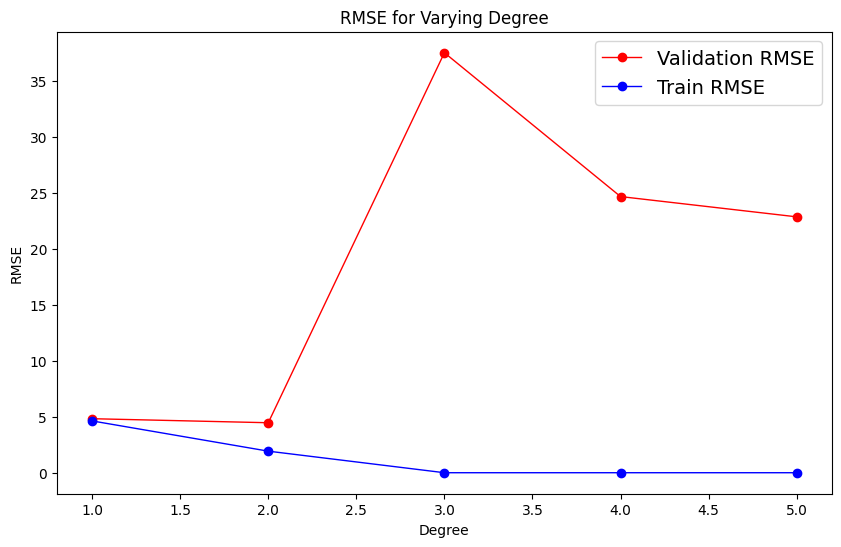


Optimal Degree:  2


In [ ]:
# Partition the training data into train and validation subsets for this experiment
X_train_new, X_validation, y_train_new, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
degreeList = [1,2,3,4,5]

# Two lists to store train and validation MSE values for various models of varying complexity
mse_train_list, mse_validation_list = [], []

for degree in degreeList:

    # Create a pipeline object: first add polynomials, then standardize, finally create Linear Regression model 
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), LinearRegression()) 
  
    # Train the model
    model.fit(X_train_new, y_train_new)
       
    # Make prediction 
    y_train_predicted = model.predict(X_train_new)
    y_validation_predicted = model.predict(X_validation)    
    
    # Compute MSE and add to the list
    mse_train_list.append(mean_squared_error(y_train_new, y_train_predicted))
    mse_validation_list.append(mean_squared_error(y_validation, y_validation_predicted))

# Plot RMSE values for varying polynomial degree
plt.figure(figsize=(10, 6))   
plt.plot(degreeList, np.sqrt(mse_validation_list), "ro-", alpha=1.0, linewidth=1.0, label="Validation RMSE")
plt.plot(degreeList, np.sqrt(mse_train_list), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")    
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.show()

# Find the value of optimal degree for the polynomial that gives smallest validation RMSE
rmse_validation = np.sqrt(mse_validation_list)
j = 0
min_rmse = rmse_validation[j]
optimal_degree = 1

for i in degreeList:
    if(rmse_validation[j] < min_rmse):
        min_rmse = rmse_validation[j]
        optimal_degree = i
    j +=1
    
print("\nOptimal Degree: ", optimal_degree)

**Computation of the Validation RMSE: Approach 2**

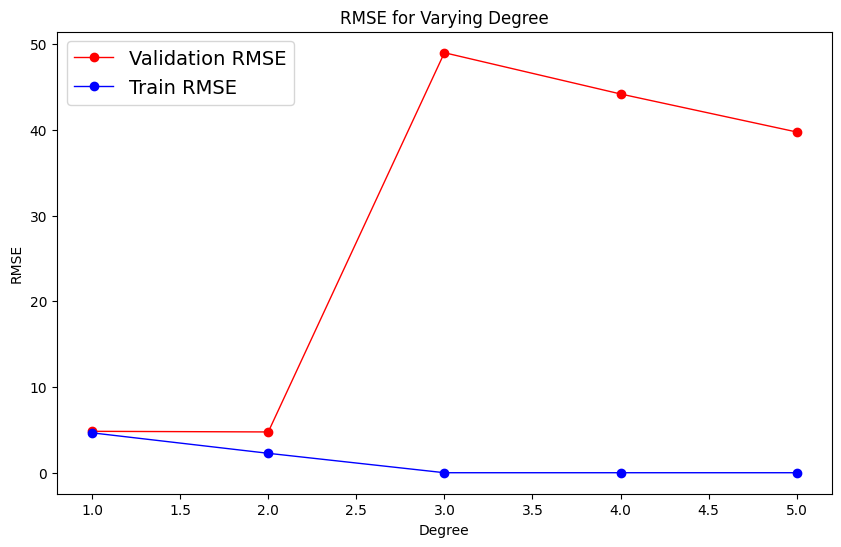

Optimal Degree:  2


In [ ]:
degreeList = [1,2,3,4,5]

# Create two lists for storing MSE values (train & validation) for various polynomial degree values
mse_train_list, mse_validation_list = [], []

for degree in degreeList:

    # Create a OLS Linear Regression model using a pipeline object
    # In the pipeline, first add the polynomial features based on the given degree
    # Then, stadardize the data
    # Finally, create the Linear Regression model
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), LinearRegression()) 
  
    # Train the model
    model.fit(X_train, y_train)

    # Make prediction using the training data 
    y_train_predicted = model.predict(X_train)

    # Compute the training MSE 
    mse_train = mean_squared_error(y_train, y_train_predicted)


    # Compute the validation MSE 
    #  - Use sklearn's metrics.cross_val_score() function that employs the cross-validation technique
    # Set its scoring argument with the value "neg_mean_squared_error" 
    # It returns a list of the negative MSE values
    # The length of the list depends on the value of the function's "cv" argument
    # Compute the mean of the negative MSE values
    # Then, multiply the mean with "-" to get the validation MSE score
    validation_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3)

    # Compute the mean of the multiple validation score values
    mse_validation = -validation_scores.mean()

    
    mse_train_list.append(mse_train)
    mse_validation_list.append(mse_validation)
   

plt.figure(figsize=(10, 6))   
plt.plot(degreeList, np.sqrt(mse_validation_list), "ro-", alpha=1.0, linewidth=1.0, label="Validation RMSE")
plt.plot(degreeList, np.sqrt(mse_train_list), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")  

plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.show()


# Find the value the polynomial degree that gives the smallest validation RMSE
j = 0
min_validation_mse = mse_validation_list[j]
optimal_degree = 1

for i in degreeList:
    if(mse_validation_list[j] < min_validation_mse):
        min_validation_mse = mse_validation_list[j]
        optimal_degree = i
    j +=1
    
print("Optimal Degree: ", optimal_degree)

**Train a Polynomial Linear Regression Model using the Optimal Degree**<br>
We use sklearn's OLS Linear Regression model to implement the Polynomial Linear Regression solution. We train the OLS LinearRegression() object with the augmented set of features.

In [ ]:
# Polynomial Regression
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = optimal_degree
# Add polynomial terms with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
print("No. of Original Features: ", X_train.shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])
# Standardize the augmented features
scaler = StandardScaler()
# Fit on training set only
scaler.fit(X_train_poly)
# Apply transform to both the training set and the test set (next block)
X_train_poly = scaler.transform(X_train_poly)
# Create a linear regression object
lin_reg_poly = LinearRegression()
# Train the model
lin_reg_poly.fit(X_train_poly, y_train)

print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_poly_predicted = lin_reg_poly.predict(X_train_poly)
# Performance evaluation
print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_poly_predicted))
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_train, y_train_poly_predicted))

No. of Original Features:  13
No. of Augmented Features:  104

----------------------------- Model Evaluation -----------------------------

Mean squared error: 5.13
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.94


**Evaluate the Model Using Test Data**<br>
We will use the optimal degree for the polynomial to evaluate the model.

In [ ]:
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = optimal_degree

# Add polynomial (without bias) with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_test_poly = poly_features.fit_transform(X_test)

# Standardize the augmented test data
X_test_poly = scaler.transform(X_test_poly)

print("\n----------------------------- Model Evaluation -----------------------------")
# Make prediction 
y_test_poly_predicted = lin_reg_poly.predict(X_test_poly)
# Performance evaluation
print("\nMean squared error: %.2f"
      % mean_squared_error(y_test, y_test_poly_predicted))
print('Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f' % r2_score(y_test, y_test_poly_predicted))


----------------------------- Model Evaluation -----------------------------

Mean squared error: 14.26
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.81


**1.2 Using learning curve to determine the optimal degree (model complexity) that produces best generalization**

Another MLE technique to determine a polynomial model's complexity (whether it's overfitting or underfitting) is to look at the learning curve.<br>

A learning curve is a plot of the model’s performance on the training set and the validation set as a function of the training set size. To generate the plots for a given degree of polynomial, simply train the model several times on different sized subsets of the training set.<br>

Scikit-Learn provides a function for plotting learning curve.

The sklearn learning_curve function determines cross-validated training and validation scores for different training set sizes.<br>

A cross-validation generator splits the whole dataset k times in training and validation data. Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the validation set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

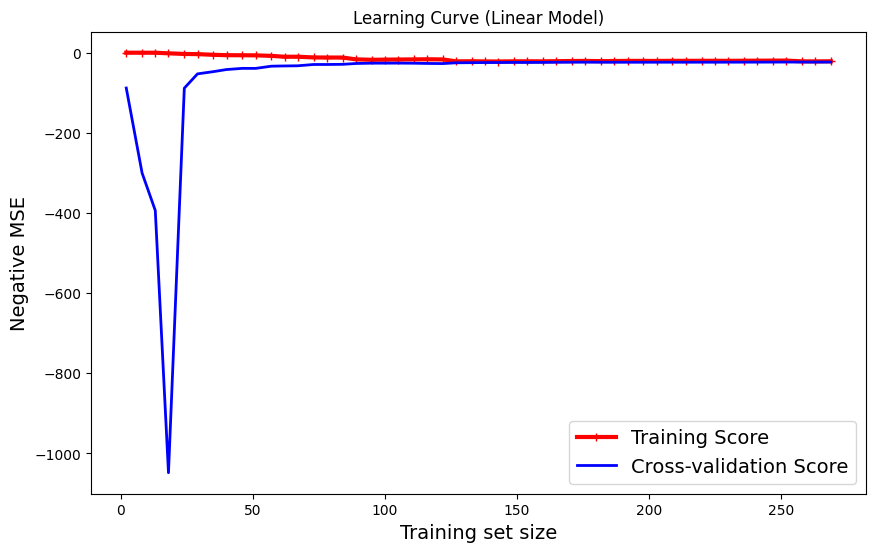

In [ ]:
# Create CV training and validation scores for various training set sizes
train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train, y_train, cv=3, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50),
                                                        n_jobs=-1)
                                                
                                                                                                                                                                                                                 
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve (Linear Model)")
plt.show()

**Observation From the Learning Curve**<br>

First, let’s look at the performance on the training data: when there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the training data goes up (goes down for negative mse) until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse.<br>

Then, look at the performance of the model on the validation data. When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then as the model is shown more training examples, it learns and thus the validation error slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve.<br>

These learning curves are typical of an underfitting model. Both curves have reached a plateau; they are close and fairly high (large negative mse).<br>

**High Bias:**<br>
A high-bias model is most likely to underfit the training data. The generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually non-linear.

**How do we reduce high-bias (resolve underfitting)?**<br>
If the model is underfitting the training data, adding more training examples will not help. We need to use a more complex model or come up with better features.

**High-Degree (4th Degree) Polynomial Model**

No. of Original Features:  13
No. of Augmented Features:  8567


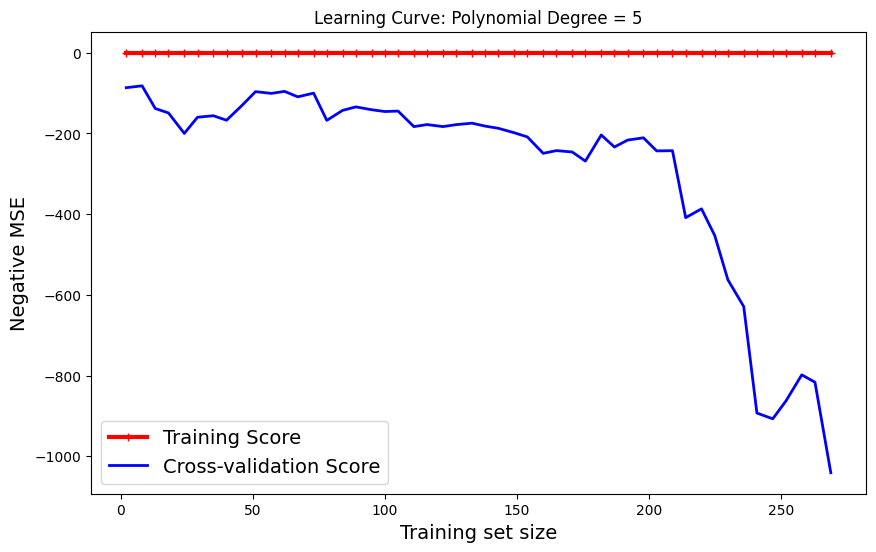

In [ ]:
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = 5

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

print("No. of Original Features: ", X_train.shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])

scaler = StandardScaler().fit(X_train_poly)
X_train_poly_standardized = scaler.transform(X_train_poly)

train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train_poly_standardized, y_train, cv=3, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))                                                                                                                                                                                                       
                                                        
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve: Polynomial Degree = %d" % poly_degree)
plt.show()

**High-Degree (4th Degree) Polynomial Model: Observation From the Learning Curve**<br>
The error on the training data is zero, but on the validation its increasing.
There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model.<br>

**High Variance:**<br>
A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance, and thus to overfit the training data. The model is excessively sensitive to small variations in the training data.

**RMSE vs Varying Degree**<br>
We plot multiple learning curves by varying the degree.

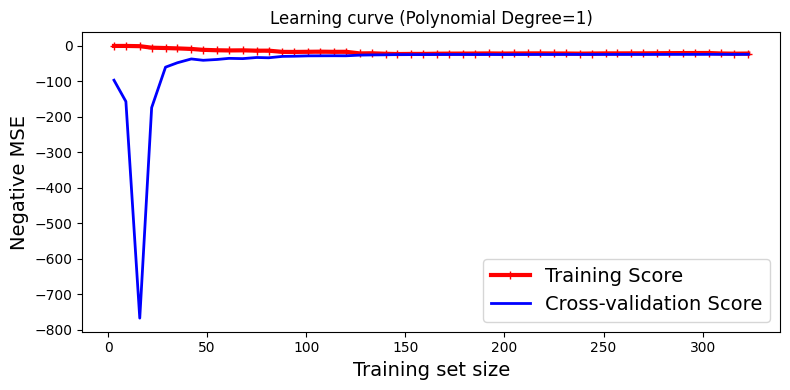

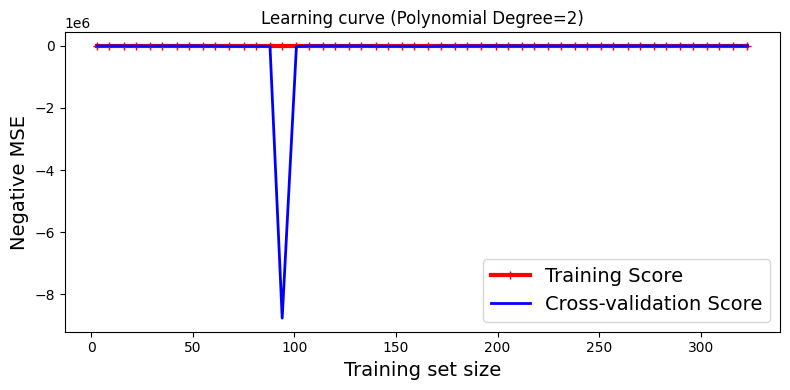

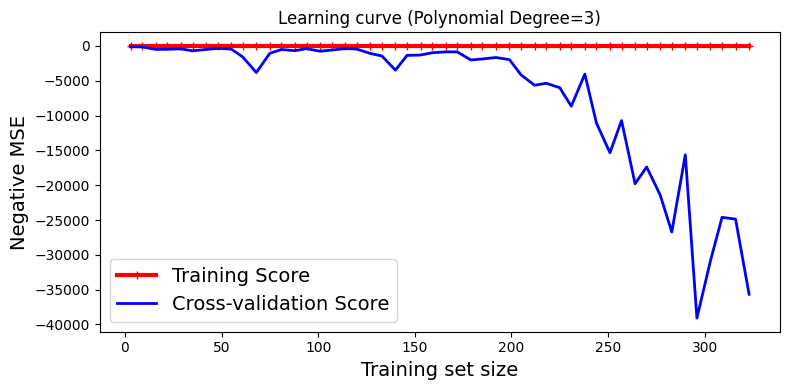

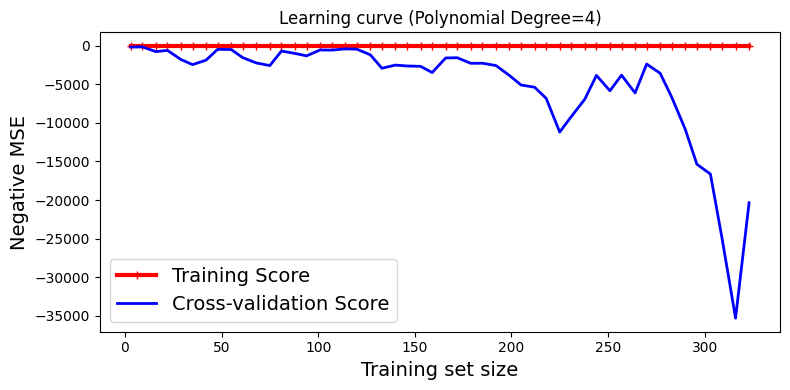

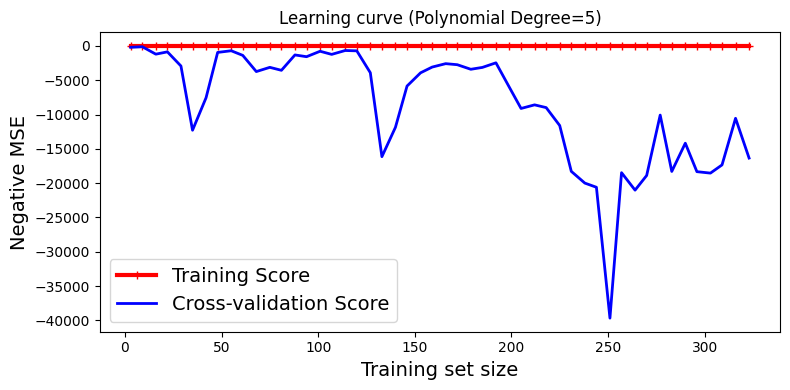

In [ ]:
warnings.filterwarnings('ignore')

for d in [1, 2, 3, 4, 5]:
    model = make_pipeline(PolynomialFeatures(degree=d), LinearRegression())

    train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, 
                                                                  scoring='neg_mean_squared_error', 
                                                                  train_sizes=np.linspace(0.01, 1.0, 50))
   
    # Create means and standard deviations of training & validation set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
   
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the mean train error and validation error across folds
    plt.figure(figsize=(8, 4))
    plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
    plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
    plt.legend(loc="best", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("Negative MSE", fontsize=14) 
    plt.title('Learning curve (Polynomial Degree=%i)' % d)
    plt.tight_layout()

plt.show()

We observe that the 2nd degree polynomial model improves the test data performance significantly better than other models. <br>

However, in general, increasing a model’s complexity (higher-degree polynomial) will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. Thus, we need to do bias-variance tradeoff. <br>

One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.<br>

When data is scare, overfitting (high variance) can be tamed by applying the Bayesian Learning aproach. In Bayesian Learning, we regularize (penalize) the model parameters.

**2- Bayesian Learning Approach for Bias-Variance Tradeoff (Choosing Model Complexity)**

Unlike the Frequentist approach (MLE) which is used to determine the optimal degree of the polynomial (how complex the model should be), the Bayesian approach enables us to determine the optimal regularization (penalty) coefficients that produce the best generalization.<br>

Recall that MLE picks the polynomial degree that is the best for modeling the training data. If the data is noisy (input and out have a nonlinear relationship), a high-degree polynomial is required that results in a complex function. Such complex models are prone to overfitting (has high variance).<br>

The Bayesian approach (Maximum a posteriori or MAP) is used to resolve this issue by encouraging the parameters to be small, thus resulting in a smoother curve. This is done by a technique called regularization. Regularization can “turn off” some features that don’t play any role in explaining the variation in our prediction. In the case of polynomial regression, it kills the non-discriminating polynomial features.<br>

Regularization allows complex models to be trained on datasets of limited size without severe overfitting, essentially by limiting the effective model complexity. We can afford a complex model without experiencing overfitting.

**Regularized (Penalized) Regression**<br>
In regularized Regression, we regularize (penalize) the model parameters that allow complex models (high-degree Polynomial Regression model) to be trained on datasets of limited size without severe overfitting. It essentially limits the effective model complexity.<br>

Thus, the problem of determining the optimal model complexity (degree of polynomial or the basis function) is shifted from one of finding the appropriate number of basis functions (that we did in the Frequentist approach) to one of determining a suitable value of the regularization coefficient.<br>

A model with some regularization typically performs better than a model without any regularization. Thus, we should generally prefer regularized Regression over plain Linear Regression.<br>

Moreover, the OLS method (Normal Equation) requires computing the inverse of a matrix, but that matrix is not always invertible. In contrast, the matrix for regularized Regression (e.g., Ridge Regression) is always invertible.<br>

To implement the Bayesian approach, we will train a high-degree polynomial model that might have high variance (suffers from overfitting). Then, we will reduce overfitting via regularization. First, we determine the optimal polynomial degree by using MLE and then reduce its overfitting.<br>

Step 1: Using Frequentist approach to determine the optimal degree of the high-degree polynomial.
Step 2: Then, apply the regularized OLS method and determine the optimal value for the regularization parameter via hyperparameter tuning. We will see that due to regularization the model will be better generalizable by weakening some of the features.

**Step 1:** Using Frequentist approach Determine the Optimal Degree of the Polynomial

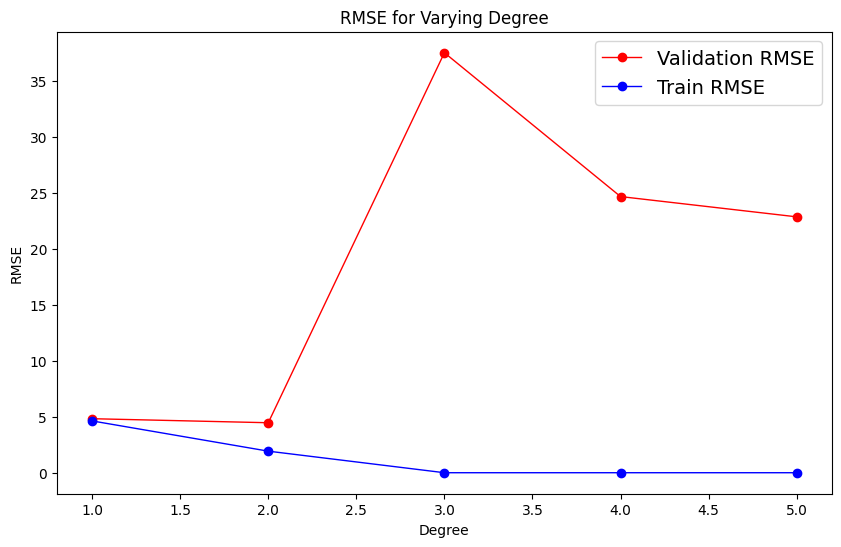


Optimal Degree:  2


In [ ]:
# Partition the training data into train and validation subsets for this experiment
X_train_new, X_validation, y_train_new, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

degreeList = [1,2,3,4,5]

# Two lists to store train and validation MSE values for various models of varying complexity
mse_train, mse_validation = [], []

for degree in degreeList:

    # Create a pipeline object: first add polynomials, then standardize, and finally create a Linear Regression model 
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), LinearRegression()) 
  
    # Train the model
    model.fit(X_train_new, y_train_new)
       
    # Make prediction 
    y_train_predicted = model.predict(X_train_new)
    y_validation_predicted = model.predict(X_validation)
        
    # Compute MSE and add to the list
    mse_train.append(mean_squared_error(y_train_new, y_train_predicted))
    mse_validation.append(mean_squared_error(y_validation, y_validation_predicted))

# Plot RMSE values for varying polynomial degree
plt.figure(figsize=(10, 6))   
plt.plot(degreeList, np.sqrt(mse_validation), "ro-", alpha=1.0, linewidth=1.0, label="Validation RMSE")
plt.plot(degreeList, np.sqrt(mse_train), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")    
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.show()

# Find the value of the optimal degree for the polynomial that gives the smallest validation RMSE
rmse_validation = np.sqrt(mse_validation)
j = 0
min_rmse = rmse_validation[j]
optimal_degree = 1

for i in degreeList:
    if(rmse_validation[j] < min_rmse):
        min_rmse = rmse_validation[j]
        optimal_degree = i
    j +=1
    
print("\nOptimal Degree: ", optimal_degree)

**Standardize the Features**

In [ ]:
scaler = StandardScaler()

# Fit on the training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**Step 2:** Apply the Regularized OLS Method (MAP) on the Optimal Polynomial Model

**1- Ridge Regression**

**Create a High-Degree Polynomial Data Matrix**

In [ ]:
# Variable that specifies the degree of the polynomial to be added to the feature vector
poly_degree = optimal_degree

# Add polynomial terms with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

print("No. of Original Features: ", X_train.shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])

No. of Original Features:  13
No. of Augmented Features:  104


**Model Selection Via Grid Search: Ridge Regression**

In [ ]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
%%time
warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'alpha': np.linspace(0.01, 1.0, num=20), 
              'solver': ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "saga"]}

ridge = Ridge()

ridge_cv = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)
ridge_cv.fit(X_train_poly, y_train)

params_optimal_ridge = ridge_cv.best_params_

print("Best Score (negative mean squared error): %f" % ridge_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_ridge)
print("\n")

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
Best Score (negative mean squared error): -12.422880
Optimal Hyperparameter Values:  {'alpha': np.float64(1.0), 'solver': 'saga'}


CPU times: total: 859 ms
Wall time: 32.5 s


**Select The Best Model for the Ridge Regressor**<br>
Using the optimal hyperparameter values, create the best model. Then, fit the model.

In [ ]:
# Ridge Regression

# Optimal model parameters
ridge_alpha = ridge_cv.best_params_['alpha']
print("Optimal alpha: ", ridge_alpha)

ridge_solver = ridge_cv.best_params_['solver']
print("Optimal alpha: ", ridge_solver)

# Create a Ridge linear regression object
lin_reg_ridge = Ridge(alpha=ridge_alpha, solver=ridge_solver)

# Train the model
lin_reg_ridge.fit(X_train_poly, y_train)

print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_ridge = lin_reg_ridge.predict(X_train_poly)
# Performance evaluation
print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_ridge))
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_train, y_train_predicted_ridge))

Optimal alpha:  1.0
Optimal alpha:  saga

----------------------------- Model Evaluation -----------------------------

Mean squared error: 6.42
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.93


**Evaluate the Model Using Test Data: Ridge Regression**<br>
We will use the optimal degree for the polynomial to evaluate the model.

In [ ]:
# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_test_poly = poly_features.fit_transform(X_test)

print("\n----------------------------- Test Model Evaluation -----------------------------")
# Make prediction 
y_test_poly_predicted = lin_reg_ridge.predict(X_test_poly)
ridge_test_mse = mean_squared_error(y_test, y_test_poly_predicted)
print("\nMean squared error: %.2f" % ridge_test_mse)
ridge_test_r2_score = r2_score(y_test, y_test_poly_predicted)
print('Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f' 
      % ridge_test_r2_score)


----------------------------- Test Model Evaluation -----------------------------

Mean squared error: 14.14
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.81


**2- Lasso Regression**

**Create a High-Degree Polynomial Data Matrix**

In [ ]:
# Variable that specifies the degree of the polynomial to be added to the feature vector
poly_degree = optimal_degree

# Add polynomial terms with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

**Model Selection Via Grid Search: Lasso Regression**

In [ ]:
%%time

warnings.filterwarnings('ignore')

param_grid = {'alpha': np.linspace(10.0, 20.0)}
lasso = Lasso()
lasso_cv = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)
lasso_cv.fit(X_train_poly, y_train)

params_optimal_lasso = lasso_cv.best_params_

print("Best Score (negative mean squared error): %f" % lasso_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_lasso)
print("\n")

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Score (negative mean squared error): -12.157443
Optimal Hyperparameter Values:  {'alpha': np.float64(15.306122448979592)}


CPU times: total: 297 ms
Wall time: 3.34 s


**Select The Best Model for the Lasso Regressor**<br>
Using the optimal hyperparameter values, create the best model. Then, fit the model.

In [ ]:
# Lasso Regression

# Optimal model parameters
lasso_alpha = lasso_cv.best_params_['alpha']
print("Optimal alpha: ", lasso_alpha)

# Create a Lasso linear regression object
lin_reg_lasso = Ridge(alpha=lasso_alpha)

# Train the model
lin_reg_lasso.fit(X_train_poly, y_train)

print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_lasso = lin_reg_lasso.predict(X_train_poly)

print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_lasso))

# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_lasso))

Optimal alpha:  15.306122448979592

----------------------------- Model Evaluation -----------------------------

Mean squared error: 6.59
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.92


**Evaluate the Model Using Test Data: Lasso Regression**<br>
We will use the optimal degree for the polynomial to evaluate the model.

In [ ]:
# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_test_poly = poly_features.fit_transform(X_test)

print("\n----------------------------- Test Model Evaluation -----------------------------")

# Make prediction 
y_test_poly_predicted = lin_reg_lasso.predict(X_test_poly)

lasso_test_mse = mean_squared_error(y_test, y_test_poly_predicted)

print("\nMean squared error: %.2f" % lasso_test_mse)

# Explained variance score: 1 is perfect prediction
lasso_test_r2_score = r2_score(y_test, y_test_poly_predicted)
print('Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f' 
      % lasso_test_r2_score)


----------------------------- Test Model Evaluation -----------------------------

Mean squared error: 13.27
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.82


**Polynomial Regression - Gradient Descent Model Selection**<br>
In this notebook, we show how to perform model selection when using Stochastic Gradient Descent (SGD) algorithm for a Polynomial Regression Model. There are two sets of hyperparameters for SGD based Polynomial Regression model.
- Polynomial degree
- SGD algorithm hyperparameters

**Model Selection**<br>
For hyperparameter tuning, we build a compound regressor using the Scikit-Learn’s Pipeline class. It will combine the PolynomialFeatures(), StandardScaler(), and SGDRegressor() objects and will create a single object.<br>

The best way to do hyperparameter tuning is to use cross-validation. We will use Scikit-Learn’s GridSearchCV to search the combinations of hyperparameter values that provide the best performance.<br>

We need to tell which hyperparameters we want the GridSearchCV to experiment with, and what values to try out. It will evaluate all the possible combinations of hyperparameter values, using cross-validation.<br>

To denote the module objects in the Pipeline we use arbitrary names: "poly", "scaler" and "sgd". We use these names to perform a grid search for the respective optimal hyperparameters.

In [ ]:
%%time
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
# Create a Pipeline object
sgd_pipeline = Pipeline([
        # Bias should be excluded because by default SGDRegressor adds bias via the "fit_intercept" parameter
        ('poly', PolynomialFeatures(include_bias=False)), 
        ('scaler', StandardScaler()),
        ('sgd', SGDRegressor(penalty='elasticnet')),
    ])

# Create a dictionary object with hyperparameters as keys and lists of corresponding values
param_grid = {'poly__degree': [1, 2, 3, 4, 5],
              'sgd__alpha': [0.1, 0.01, 0.001, 0.0001], 
              'sgd__l1_ratio': [1, 0.7, 0.5, 0.2, 0], 'sgd__max_iter':[500, 1000],
              'sgd__eta0': [0.01, 0.001, 0.0001]}

# Create a GridSearchCV object and perform hyperparameter tuning
sgd = GridSearchCV(sgd_pipeline, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# The model is trained with optimal hyperparameters, thus its the optimal model
sgd.fit(X_train, y_train)

# Get the optimal hyperparameters
params_optimal_sgd = sgd.best_params_

print("Best Score (negative mean squared error): %f" % sgd.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgd)
print("\n")

Fitting 3 folds for each of 600 candidates, totalling 1800 fits
Best Score (negative mean squared error): -12.220017
Optimal Hyperparameter Values:  {'poly__degree': 2, 'sgd__alpha': 0.01, 'sgd__eta0': 0.001, 'sgd__l1_ratio': 0.7, 'sgd__max_iter': 500}


CPU times: total: 2.34 s
Wall time: 3min 14s


**Model Evaluation**<br>
We use the optimal model created above for its evaluation based on training and test data. There is no need to train the model again by using the optimal hyperparameters.<br>

Note that the model is a Pipeline object. Before making predictions, it will transform the data by applying the optimal degree and standardization. Thus, we don't need to separately add polynomial terms and perform standardization for making predictions.

In [ ]:
# Training data: Make a prediction 
y_train_predicted_sgd = sgd.predict(X_train)

print("Train: Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_sgd))

# Training data: Explained variance score: 1 is perfect prediction
print("Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_sgd))

# Test data: Make a prediction 
y_test_predicted = sgd.predict(X_test)

print("\nTest: Mean squared error: %.2f"
      % mean_squared_error(y_test, y_test_predicted))

# Training data: Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test, y_test_predicted))

Train: Mean squared error: 6.82
Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.92

Test: Mean squared error: 13.14
Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.82
